# Environment check (and optional install)

In [4]:
import sys, os, platform, subprocess, json
from typing import Optional, Tuple
from collections import Counter, defaultdict
import os, csv, re, random
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import tensorflow as tf
print("Python:", sys.version)
print("Platform:", platform.platform())

try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    print("GPU Available:", len(tf.config.list_physical_devices("GPU")) > 0)
except Exception as e:
    print("TensorFlow not installed yet:", e)

# Optional: install repo dependencies inside this kernel (run once if needed)
#subprocess.run([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"], check=False)

Python: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26200-SP0
TensorFlow: 2.10.1
GPU Available: True


# Configure paths & hyperparameters

In [6]:
# <<< EDIT ME >>>
ROOT_DATA = "data"   # Parent folder containing your PV01/PV03/PV08 folders
SPLITS_CSV = "data/segmentation/splits.csv"
MASK_SUFFIX = "_label"                   # Change if your masks use a different suffix

# Training params
IMG_SIZE = 128
BATCH    = 24
EPOCHS   = 8
RUN_DIR  = "reports/seg_unet"           # Where training outputs will go


# Build 60/20/20 splits for segmentation

In [10]:
import sys, subprocess, os
os.makedirs(os.path.dirname(SPLITS_CSV), exist_ok=True)

cmd = [
    sys.executable, "-m", "src.data_prep.make_splits",
    "--mode", "seg",
    "--root", ROOT_DATA,
    "--out", SPLITS_CSV,
    "--seg_same_dir",
    "--mask_suffix", MASK_SUFFIX,
    "--img_exts", ".bmp,.png,.jpg",
    "--mask_exts", ".bmp,.png,.jpg",
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done ->", SPLITS_CSV)


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.data_prep.make_splits --mode seg --root data --out data/segmentation/splits.csv --seg_same_dir --mask_suffix _label --img_exts .bmp,.png,.jpg --mask_exts .bmp,.png,.jpg
Done -> data/segmentation/splits.csv


# Quick peek at the CSV

In [13]:
df = pd.read_csv(SPLITS_CSV)
df.head()

,split,image_path,mask_path
0,train,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...,data\PV01\PV01_Rooftop_Brick\PV01_325373_12038...
1,train,data\PV08\PV08_Ground\PV08_327808_1209367.bmp,data\PV08\PV08_Ground\PV08_327808_1209367_labe...
2,train,data\PV03\PV03_Ground_Cropland\PV03_341693_119...,data\PV03\PV03_Ground_Cropland\PV03_341693_119...
3,train,data\PV03\PV03_Ground_Cropland\PV03_336536_120...,data\PV03\PV03_Ground_Cropland\PV03_336536_120...
4,train,data\PV03\PV03_Ground_Cropland\PV03_348066_116...,data\PV03\PV03_Ground_Cropland\PV03_348066_116...


# Visual sanity check (a few image/mask pairs)

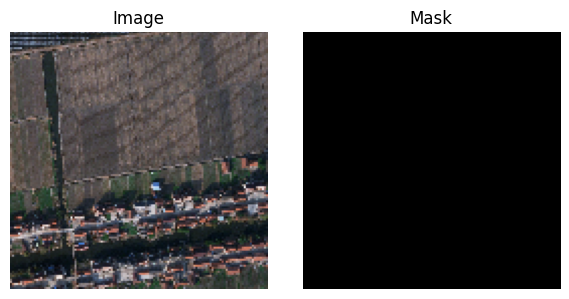

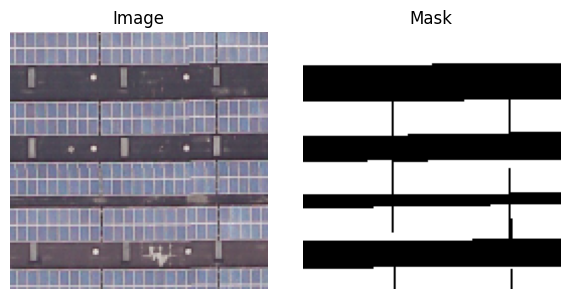

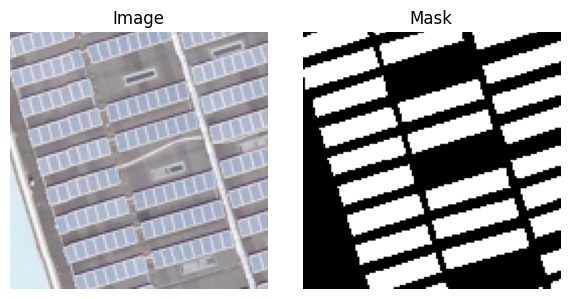

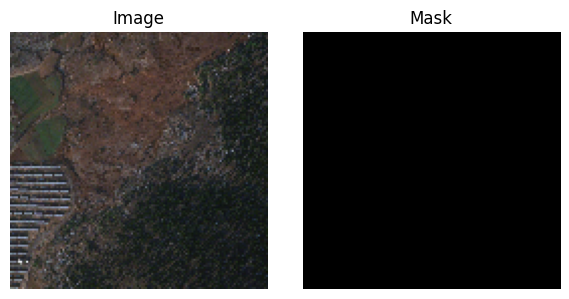

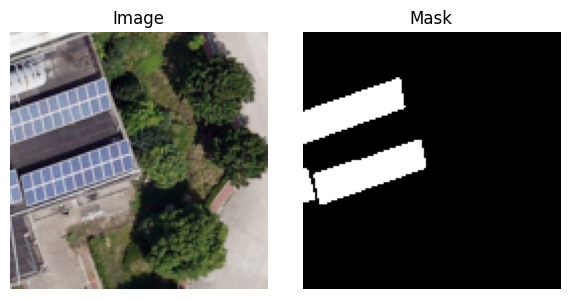

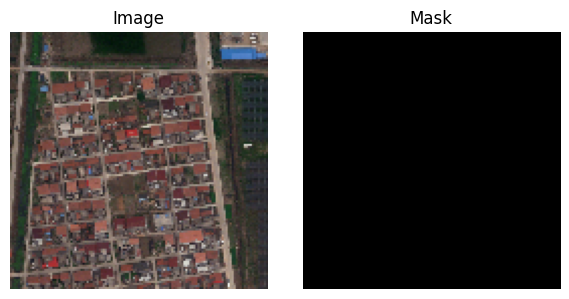

In [18]:
def load_image_mask(img_path, msk_path, img_size):
    # Image: OK to decode with 3 channels
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    # Mask: decode with 3 channels (works for BMP/PNG/JPG), then convert to grayscale
    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # <-- changed from channels=1
    msk = tf.image.rgb_to_grayscale(msk)                                   # <-- ensure single channel
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)                                   # binarize
    return img.numpy(), msk.numpy()

sub = df[df["split"]=="train"].sample(n=min(6, len(df)))
for _, r in sub.iterrows():
    img, msk = load_image_mask(r.image_path, r.mask_path, IMG_SIZE)
    fig, ax = plt.subplots(1, 2, figsize=(6,3))
    ax[0].imshow(img); ax[0].set_title("Image"); ax[0].axis("off")
    ax[1].imshow(msk.squeeze(), cmap="gray"); ax[1].set_title("Mask"); ax[1].axis("off")
    plt.tight_layout()
    plt.show()


# Train segmentation (U-Net + MobileNetV2 encoder)

In [21]:
os.makedirs(RUN_DIR, exist_ok=True)

cmd = [
    sys.executable, "-m", "src.seg.train_seg",
    "--csv", SPLITS_CSV, "--out", RUN_DIR,
    "--epochs", str(EPOCHS), "--batch", str(BATCH), "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Saved model & logs in:", RUN_DIR)


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.seg.train_seg --csv data/segmentation/splits.csv --out reports/seg_unet --epochs 8 --batch 24 --img 128
Saved model & logs in: reports/seg_unet


## Plot training history

,epoch,binary_accuracy,dice_coef,iou,loss,val_binary_accuracy,val_dice_coef,val_iou,val_loss
0,0,0.932456,0.027814,0.572039,0.213426,0.943151,0.048119,0.831765,0.106744
1,1,0.962422,0.068261,0.859986,0.066128,0.969909,0.080253,0.895574,0.063621
2,2,0.981643,0.096966,0.908670,0.043316,0.982903,0.108127,0.861027,0.047245
3,3,0.987925,0.115729,0.921510,0.030398,0.987395,0.123711,0.928939,0.032186
4,4,0.990467,0.122619,0.934424,0.024962,0.989663,0.127095,0.935707,0.026173
5,5,0.991596,0.128194,0.938919,0.021209,0.990394,0.129773,0.948378,0.023558
6,6,0.991438,0.126640,0.940975,0.022271,0.988175,0.124234,0.946183,0.029749
7,7,0.992745,0.131405,0.946603,0.018367,0.990020,0.129972,0.882480,0.026045


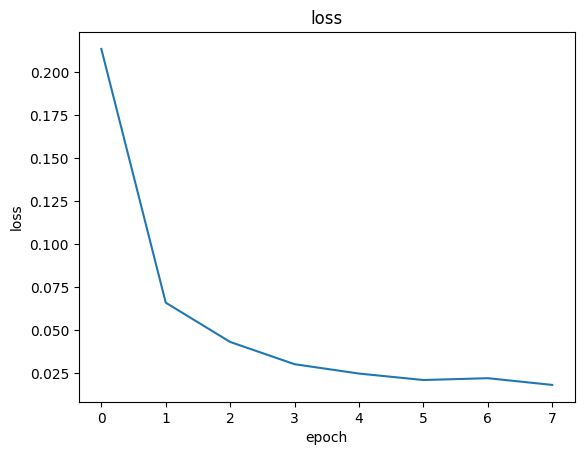

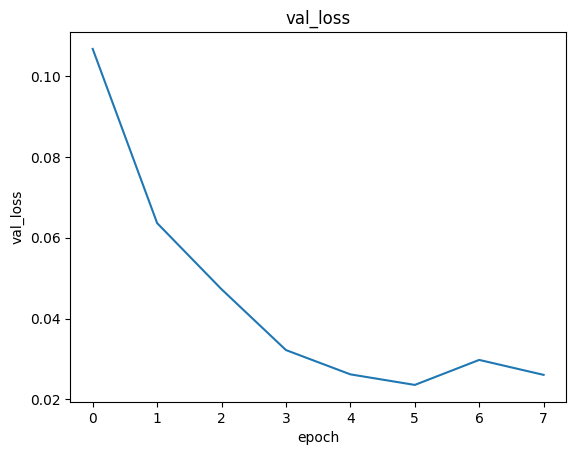

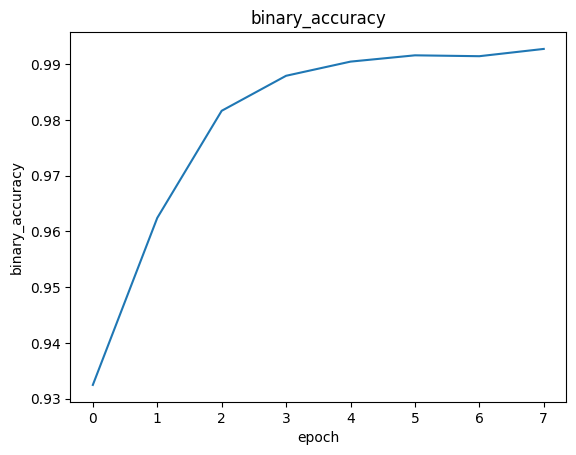

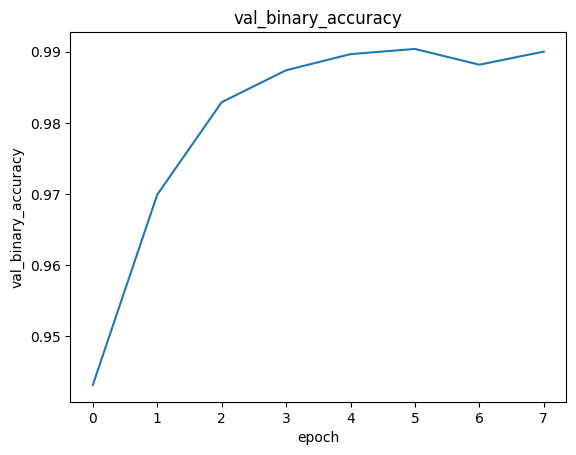

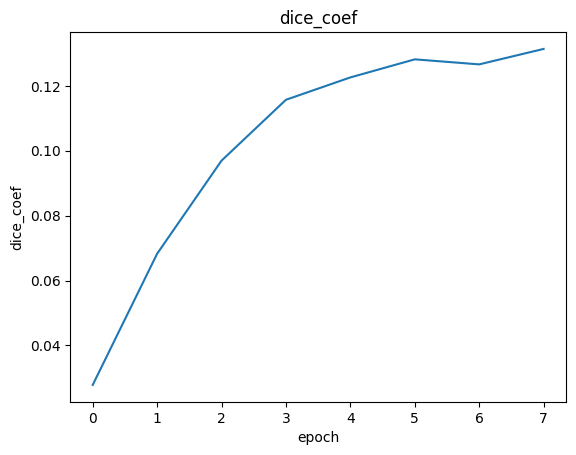

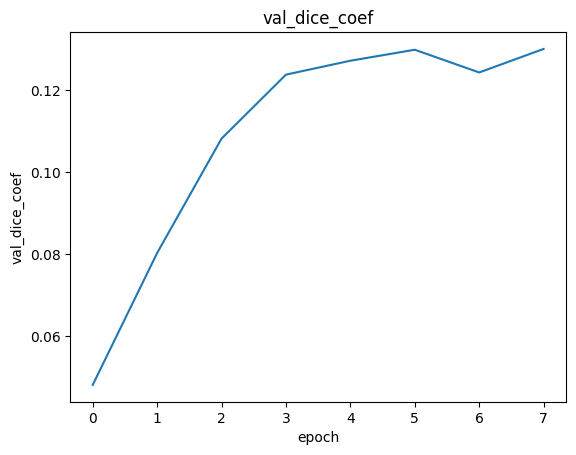

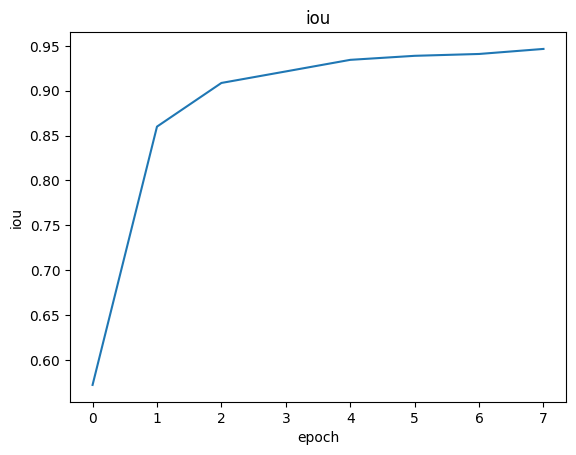

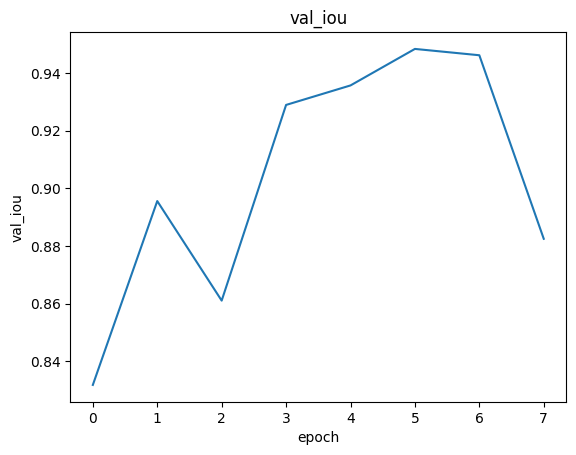

In [26]:
hist_path = os.path.join(RUN_DIR, "history.csv")
h = pd.read_csv(hist_path)
display(h.head(10))

for col in ["loss","val_loss","binary_accuracy","val_binary_accuracy","dice_coef","val_dice_coef","iou","val_iou"]:
    if col in h:
        plt.figure()
        plt.plot(h[col])
        plt.title(col)
        plt.xlabel("epoch"); plt.ylabel(col)
        plt.show()


# Evaluate on the test set

In [29]:
EVAL_DIR = os.path.join(RUN_DIR, "eval")
cmd = [
    sys.executable, "-m", "src.seg.eval_seg",
    "--csv", SPLITS_CSV,
    "--model", os.path.join(RUN_DIR, "best.keras"),
    "--out", EVAL_DIR,
    "--img", str(IMG_SIZE),
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

with open(os.path.join(EVAL_DIR, "test_metrics.json"), "r") as f:
    metrics = json.load(f)
metrics


Running: C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.seg.eval_seg --csv data/segmentation/splits.csv --model reports/seg_unet\best.keras --out reports/seg_unet\eval --img 128


{'binary_accuracy': 0.9893521666526794,
 'dice': 0.13230887055397034,
 'iou': 0.9287673830986023,
 'n_test': 744}

In [31]:
metrics.keys()

dict_keys(['binary_accuracy', 'dice', 'iou', 'n_test'])

In [33]:
metrics.values()

dict_values([0.9893521666526794, 0.13230887055397034, 0.9287673830986023, 744])

In [35]:
pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['value'])

,value
binary_accuracy,0.989352
dice,0.132309
iou,0.928767
n_test,744.000000


# Visualising the Segmentation Results

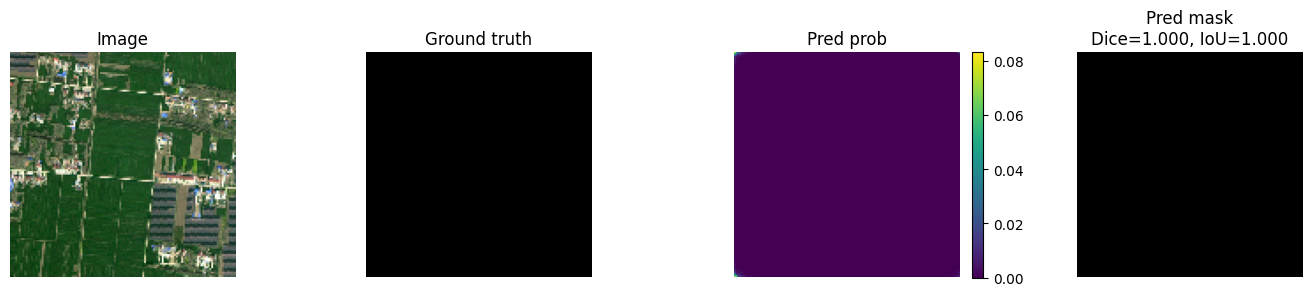

In [104]:
CSV         = "data/segmentation/splits.csv"
MODEL_PATH  = "reports/seg_unet/best.keras"   # or last.keras
IMG_SIZE    = 128                              # must match what you trained with
THRESH      = 0.5                              # binarization threshold for predictions

# --- BMP-safe loader (3-channel decode then grayscale for masks) ---
def load_image_mask_bmp_safe(img_path, msk_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # BMP/PNG/JPG
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32) / 255.0

    msk = tf.io.read_file(msk_path)
    msk = tf.image.decode_image(msk, channels=3, expand_animations=False)  # BMP-safe
    msk = tf.image.rgb_to_grayscale(msk)
    msk = tf.image.resize(msk, (img_size, img_size), method="nearest")
    msk = tf.cast(msk > 127, tf.float32)  # binarize GT
    return img.numpy(), msk.numpy().squeeze()

def dice_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    return (2*inter + eps) / (y_true.sum() + y_pred.sum() + eps)

def iou_np(y_true, y_pred, eps=1e-7):
    y_true = y_true.astype(np.float32).ravel()
    y_pred = y_pred.astype(np.float32).ravel()
    inter  = (y_true * y_pred).sum()
    union  = y_true.sum() + y_pred.sum() - inter
    return (inter + eps) / (union + eps)

# Load a random test sample
df = pd.read_csv(CSV)
test_df = df[df["split"] == "test"]
row = test_df.sample(2).iloc[0]

img, msk_true = load_image_mask_bmp_safe(row.image_path, row.mask_path, IMG_SIZE)

# Load model (no custom objects needed for inference)
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Predict
prob = model(tf.expand_dims(img, 0), training=False).numpy()[0, :, :, 0]
msk_pred = (prob >= THRESH).astype(np.float32)

# Metrics
d = dice_np(msk_true, msk_pred)
j = iou_np(msk_true, msk_pred)

# Plot
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].imshow(img);                  ax[0].set_title("Image");               ax[0].axis("off")
ax[1].imshow(msk_true, cmap="gray");ax[1].set_title("Ground truth");        ax[1].axis("off")
im = ax[2].imshow(prob, cmap="viridis"); ax[2].set_title("Pred prob");      ax[2].axis("off")
fig.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)
ax[3].imshow(msk_pred, cmap="gray"); ax[3].set_title(f"Pred mask\nDice={d:.3f}, IoU={j:.3f}"); ax[3].axis("off")
plt.tight_layout(); plt.show()


# Export the Segmentation Mask

In [107]:
# --- EDIT THESE ---
CLS_CSV     = "data/classification/splits_spfnet.csv"     # your classification CSV: split,filepath,label
SEG_MODEL   = "reports/seg_unet/best.keras"               # your trained U-Net
OUT_ROOT    = "data/classification/localized"             # where outputs go
MODE        = "both"     # "masked", "cropped", or "both"
IMG_INFER   = 128        # U-Net input size
THRESHOLD   = 0.5        # mask threshold [0..1]
PAD         = 10         # pixels to pad bbox for crops
MIN_AREA    = 500        # drop components smaller than this (in pixels)
ALPHA       = False      # masked images as RGBA (True) or black background RGB (False)
ON_EMPTY    = "copy"     # "copy", "skip", or "mask_zero" when mask is empty
EXT         = "png"      # "png" or "jpg"
# -------------------

import os, json, math, numpy as np, pandas as pd
from pathlib import Path
import tensorflow as tf
from PIL import Image

# Optional: OpenCV / SciPy (for morphology & connected components)
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

try:
    from scipy import ndimage as ndi
    HAS_ND = True
except Exception:
    HAS_ND = False

print("TF:", tf.__version__, "| OpenCV:", HAS_CV2, "| SciPy.ndimage:", HAS_ND)


TF: 2.10.1 | OpenCV: False | SciPy.ndimage: True


In [109]:
# Examples to drop into your config cell:
IMG_INFER   = 512        # or 512 if your GPU can handle it
THRESHOLD   = 0.5        # used if THRESH_MODE == 'fixed'
THRESH_MODE = "otsu"     # 'fixed' or 'otsu' (requires OpenCV)
PAD         = 16
MIN_AREA    = 1500
DILATE_PX   = 4
CLOSE_PX    = 5
ALPHA       = False
EXT         = "png"      # lossless


## Helpers (BMP-safe decode, mask post-processing, mask→image ops)

In [112]:
def decode_rgb(img_path: str) -> np.ndarray:
    """Read any image (JPG/PNG/BMP) as RGB float32 [0,1], BMP-safe (channels=3)."""
    b = tf.io.read_file(img_path)
    x = tf.image.decode_image(b, channels=3, expand_animations=False)
    return (tf.cast(x, tf.float32) / 255.0).numpy()  # HxWx3

def infer_mask(seg_model, img_rgb01: np.ndarray, img_infer: int) -> np.ndarray:
    """Run U-Net on resized image and return probability mask resized back to original size."""
    H, W, _ = img_rgb01.shape
    x = tf.image.resize(img_rgb01, (img_infer, img_infer))
    prob = seg_model(tf.expand_dims(x, 0), training=False).numpy()[0]
    if prob.ndim == 3:  # HxWx1
        prob = prob[..., 0]
    prob_full = tf.image.resize(prob[..., None], (H, W), method="nearest").numpy()[..., 0]
    return prob_full  # float32 [0..1]

def postprocess_mask(prob_map: np.ndarray, thr: float, min_area: int) -> np.ndarray:
    """Threshold + remove tiny blobs + light closing. Return uint8 mask {0,255}."""
    m = (prob_map >= thr).astype(np.uint8)

    if min_area > 0:
        if HAS_CV2:
            n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
            keep = np.zeros_like(m)
            for i in range(1, n):
                if stats[i, cv2.CC_STAT_AREA] >= min_area:
                    keep[labels == i] = 1
            m = keep
        elif HAS_ND:
            lbl, n = ndi.label(m)
            sizes = ndi.sum(m, lbl, index=np.arange(1, n+1))
            keep = np.zeros_like(m)
            for i, size in enumerate(sizes, start=1):
                if size >= min_area:
                    keep[lbl == i] = 1
            m = keep
        # else: leave as-is

    if HAS_CV2:
        kernel = np.ones((5,5), np.uint8)
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)

    return (m * 255).astype(np.uint8)

# replace your bbox_from_mask definition with this:
def bbox_from_mask(mask_u8: np.ndarray, pad: int) -> Optional[Tuple[int, int, int, int]]:
    ys, xs = np.where(mask_u8 > 0)
    if len(ys) == 0:
        return None
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    y0 = max(0, y0 - pad)
    x0 = max(0, x0 - pad)
    y1 = y1 + pad
    x1 = x1 + pad
    return (y0, y1, x0, x1)


def apply_mask(img_rgb01: np.ndarray, mask_u8: np.ndarray, alpha: bool) -> Image.Image:
    img_u8 = (np.clip(img_rgb01, 0, 1) * 255.0).astype(np.uint8)
    if alpha:
        rgba = np.dstack([img_u8, mask_u8])
        return Image.fromarray(rgba, mode="RGBA")
    else:
        masked = img_u8.copy()
        m = (mask_u8 > 0)
        masked[~m] = 0
        return Image.fromarray(masked, mode="RGB")


def crop_panel(img_rgb01: np.ndarray, mask_u8: np.ndarray, pad: int) -> Optional[Image.Image]:
    H, W, _ = img_rgb01.shape
    bb = bbox_from_mask(mask_u8, pad)
    if bb is None:
        return None
    y0, y1, x0, x1 = bb
    y1 = min(H, y1)
    x1 = min(W, x1)
    crop = (np.clip(img_rgb01[y0:y1, x0:x1], 0, 1) * 255.0).astype(np.uint8)
    return Image.fromarray(crop, "RGB")



In [114]:
# === Improved helpers for sharp masks & crops ===
from typing import Optional, Tuple
import numpy as np, tensorflow as tf
from PIL import Image

# Optional morphology / threshold helpers
try:
    import cv2
    HAS_CV2 = True
except Exception:
    HAS_CV2 = False

def decode_rgb(img_path: str) -> np.ndarray:
    """BMP-safe decode to float32 [0,1], no resize."""
    b = tf.io.read_file(img_path)
    x = tf.image.decode_image(b, channels=3, expand_animations=False)
    return (tf.cast(x, tf.float32) / 255.0).numpy()

# ---------- Letterbox (no stretching) ----------
def letterbox(img01: np.ndarray, size: int, pad_val: float = 0.0):
    """Resize with preserved aspect, pad to (size,size). Returns img_sq, scale, (pad_y, pad_x)."""
    H, W, _ = img01.shape
    s = min(size / H, size / W)
    newH, newW = int(round(H * s)), int(round(W * s))
    img_res = tf.image.resize(img01, (newH, newW), method="bilinear").numpy()
    pad_y = size - newH
    pad_x = size - newW
    top = pad_y // 2
    left = pad_x // 2
    img_sq = np.ones((size, size, 3), dtype=np.float32) * pad_val
    img_sq[top:top+newH, left:left+newW] = img_res
    return img_sq, s, (top, left), (newH, newW)

def unletterbox_mask(mask_sq: np.ndarray, orig_shape: Tuple[int,int], scale: float, pad: Tuple[int,int], newHW: Tuple[int,int]):
    """Map square mask back to original HxW; trims padding, then resizes back with nearest."""
    H0, W0 = orig_shape
    top, left = pad
    newH, newW = newHW
    # crop out padding from the square
    crop = mask_sq[top:top+newH, left:left+newW]
    # resize back to original size (nearest to keep edges)
    mask_full = tf.image.resize(crop[..., None], (H0, W0), method="nearest").numpy()[..., 0]
    return mask_full

# ---------- Inference & post-processing ----------
def infer_prob_map(seg_model, img01: np.ndarray, img_infer: int) -> np.ndarray:
    """Run U-Net with letterbox; return float prob map at original size."""
    H0, W0, _ = img01.shape
    img_sq, scale, pad, newHW = letterbox(img01, img_infer, pad_val=0.0)
    prob_sq = seg_model(tf.expand_dims(img_sq, 0), training=False).numpy()[0]
    if prob_sq.ndim == 3:
        prob_sq = prob_sq[..., 0]
    # undo letterbox
    prob = unletterbox_mask(prob_sq, (H0, W0), scale=scale, pad=pad, newHW=newHW)
    return prob  # float32 [0..1]

def threshold_prob(prob: np.ndarray, thr: float, mode: str = "fixed") -> np.ndarray:
    """Return binary mask {0,1} using fixed/otsu; optional pre-blur for smoother edges."""
    p = prob.copy()
    if HAS_CV2:
        p = cv2.GaussianBlur(p, (0,0), sigmaX=1.0)  # mild anti-alias before threshold
    if mode == "otsu" and HAS_CV2:
        # Otsu expects 8-bit
        p8 = (np.clip(p, 0, 1) * 255).astype(np.uint8)
        _, m = cv2.threshold(p8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return (m > 0).astype(np.uint8)
    # default fixed threshold
    return (p >= thr).astype(np.uint8)

def polish_mask(mbin: np.ndarray, min_area: int = 500, close_px: int = 5, dilate_px: int = 3) -> np.ndarray:
    """Remove tiny blobs, close holes, and dilate a touch for safer crops."""
    m = mbin.astype(np.uint8)
    if HAS_CV2:
        n, labels, stats, _ = cv2.connectedComponentsWithStats(m, connectivity=8)
        keep = np.zeros_like(m)
        for i in range(1, n):
            if stats[i, cv2.CC_STAT_AREA] >= min_area:
                keep[labels == i] = 1
        m = keep
        if close_px > 0:
            k = max(1, int(close_px))
            kernel = np.ones((k, k), np.uint8)
            m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, kernel)
        if dilate_px > 0:
            k = max(1, int(dilate_px))
            kernel = np.ones((k, k), np.uint8)
            m = cv2.dilate(m, kernel, iterations=1)
    return m

# ---------- Mask application & crop ----------
def apply_mask(img01: np.ndarray, prob: np.ndarray, hard_mask: bool = True, thr: float = 0.5,
               alpha_rgba: bool = False, soft_tau: float = 0.1, soft_gamma: float = 1.0) -> Image.Image:
    """
    If hard_mask: threshold & zero background.
    Else: soft blending with mask^gamma and temperature tau (crisper yet smooth edges).
    """
    img_u8 = (np.clip(img01, 0, 1) * 255).astype(np.uint8)
    if hard_mask:
        m = (prob >= thr).astype(np.uint8)
        if alpha_rgba:
            return Image.fromarray(np.dstack([img_u8, (m*255).astype(np.uint8)]), "RGBA")
        else:
            masked = img_u8.copy()
            masked[~m.astype(bool)] = 0
            return Image.fromarray(masked, "RGB")
    # soft mask
    # temperature sharpen: sigmoid((p - thr) / tau)
    m = 1.0 / (1.0 + np.exp(-(prob - thr) / max(1e-6, soft_tau)))
    m = np.power(m, soft_gamma)
    masked = (img01 * m[..., None])
    return Image.fromarray((np.clip(masked, 0, 1) * 255).astype(np.uint8), "RGB")

def bbox_from_mask(m: np.ndarray, pad: int) -> Optional[Tuple[int,int,int,int]]:
    ys, xs = np.where(m > 0)
    if len(ys) == 0:
        return None
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())
    return max(0, y0 - pad), y1 + pad, max(0, x0 - pad), x1 + pad

def crop_panel(img01: np.ndarray, m: np.ndarray, pad: int, rotate: bool = True) -> Optional[Image.Image]:
    """
    Axis-aligned crop; if OpenCV is available and rotate=True, use minAreaRect
    to get a tighter, oriented crop (often looks sharper).
    """
    H, W, _ = img01.shape
    if HAS_CV2 and rotate and np.any(m):
        pts = np.column_stack(np.where(m > 0)).astype(np.int32)   # (N,2) -> (y,x)
        pts_xy = np.fliplr(pts).astype(np.float32)                # (x,y)
        rect = cv2.minAreaRect(pts_xy)
        box  = cv2.boxPoints(rect).astype(np.float32)             # 4x2
        # compute warp to upright rectangle
        w = int(rect[1][0]); h = int(rect[1][1])
        if w == 0 or h == 0:
            # fallback to axis-aligned
            bb = bbox_from_mask(m, pad)
        else:
            # destination box (upright)
            dst = np.array([[0, h-1], [0, 0], [w-1, 0], [w-1, h-1]], dtype=np.float32)
            M = cv2.getPerspectiveTransform(box, dst)
            img_u8 = (np.clip(img01, 0, 1) * 255).astype(np.uint8)
            warp = cv2.warpPerspective(img_u8, M, (w, h), flags=cv2.INTER_LANCZOS4)
            return Image.fromarray(warp, "RGB")
    # axis-aligned
    bb = bbox_from_mask(m, pad)
    if bb is None:
        return None
    y0, y1, x0, x1 = bb
    y1 = min(H, y1); x1 = min(W, x1)
    crop = (np.clip(img01[y0:y1, x0:x1], 0, 1) * 255).astype(np.uint8)
    return Image.fromarray(crop, "RGB")

# High-quality save
def save_image(pil_img: Image.Image, path: str):
    path = str(path)
    if path.lower().endswith(".jpg") or path.lower().endswith(".jpeg"):
        pil_img.save(path, quality=95, subsampling=0, optimize=True)
    else:
        pil_img.save(path, compress_level=3)  # PNG (fast, lossless)


## Exporter (writes masked/cropped images + new CSVs)

In [121]:
# Create output folders
OUT_ROOT = Path(OUT_ROOT)
OUT_MASKED = OUT_ROOT / "masked"
OUT_CROPPED = OUT_ROOT / "cropped"
if MODE in ("masked", "both"):  OUT_MASKED.mkdir(parents=True, exist_ok=True)
if MODE in ("cropped", "both"): OUT_CROPPED.mkdir(parents=True, exist_ok=True)

# Load model once
print("Loading segmentation model:", SEG_MODEL)
seg_model = tf.keras.models.load_model(SEG_MODEL, compile=False)

# Load CSV
df = pd.read_csv(CLS_CSV)
assert {"split","filepath","label"}.issubset(df.columns), "CSV must have columns: split, filepath, label"

rows_masked, rows_cropped = [], []

# Make class/ split directories up-front
for split in df.split.unique():
    labels = df.loc[df.split == split, "label"].unique()
    for lb in labels:
        if MODE in ("masked", "both"):  (OUT_MASKED / split / lb).mkdir(parents=True, exist_ok=True)
        if MODE in ("cropped", "both"): (OUT_CROPPED / split / lb).mkdir(parents=True, exist_ok=True)

# Iterate rows (use tqdm if you like)
for idx, r in df.iterrows():
    img_path, split, label = r.filepath, r.split, r.label
    try:
        img = decode_rgb(img_path)
    except Exception as e:
        print(f"[WARN] ({idx}) read fail: {img_path} -> {e}")
        continue

    prob   = infer_mask(seg_model, img, IMG_INFER)
    mask_u8 = postprocess_mask(prob, THRESHOLD, MIN_AREA)
    base = Path(img_path).stem

    if MODE in ("masked", "both"):
        masked_img = apply_mask(img, mask_u8, alpha=ALPHA)
        outp = OUT_MASKED / split / label / f"{base}_masked.{EXT}"
        masked_img.save(outp)
        rows_masked.append((split, str(outp), label))

    if MODE in ("cropped", "both"):
        cropped_img = crop_panel(img, mask_u8, PAD)
        if cropped_img is None:
            if ON_EMPTY == "skip":
                pass
            elif ON_EMPTY == "mask_zero":
                cropped_img = Image.fromarray(np.zeros((8,8,3), np.uint8), "RGB")
            else:  # copy original
                cropped_img = Image.fromarray((img*255).astype(np.uint8), "RGB")
        if cropped_img is not None:
            outp = OUT_CROPPED / split / label / f"{base}_crop.{EXT}"
            cropped_img.save(outp)
            rows_cropped.append((split, str(outp), label))

# Write new CSVs
CSV_MASKED  = OUT_ROOT / "splits_localized_masked.csv"
CSV_CROPPED = OUT_ROOT / "splits_localized_cropped.csv"
if rows_masked:
    pd.DataFrame(rows_masked, columns=["split","filepath","label"]).to_csv(CSV_MASKED, index=False)
    print("Wrote:", CSV_MASKED)
if rows_cropped:
    pd.DataFrame(rows_cropped, columns=["split","filepath","label"]).to_csv(CSV_CROPPED, index=False)
    print("Wrote:", CSV_CROPPED)

print("Done.")


Loading segmentation model: reports/seg_unet/best.keras


AssertionError: CSV must have columns: split, filepath, label

## Quick visual sanity-check

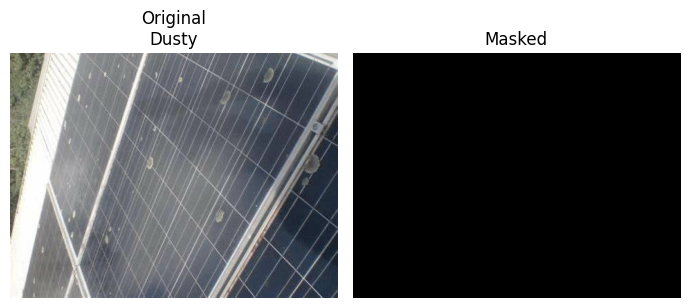

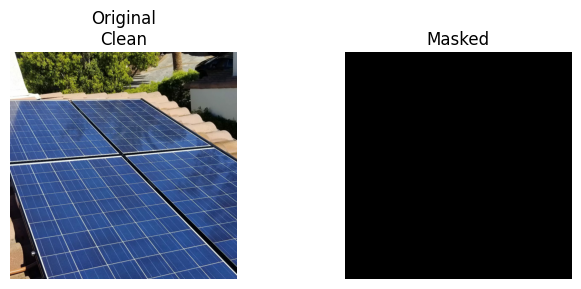

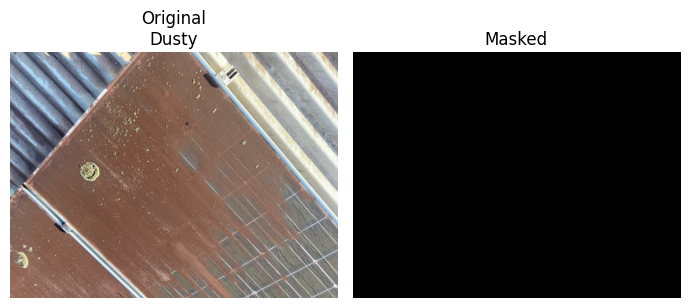

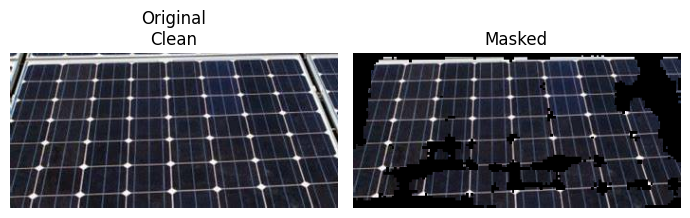

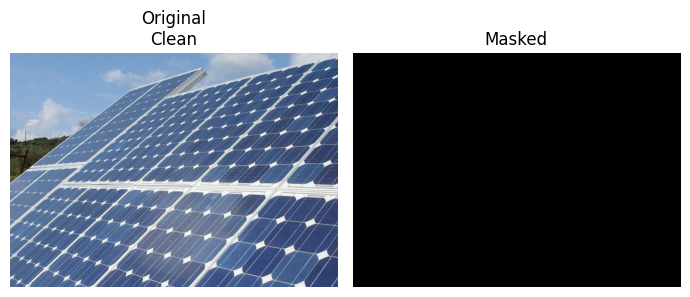

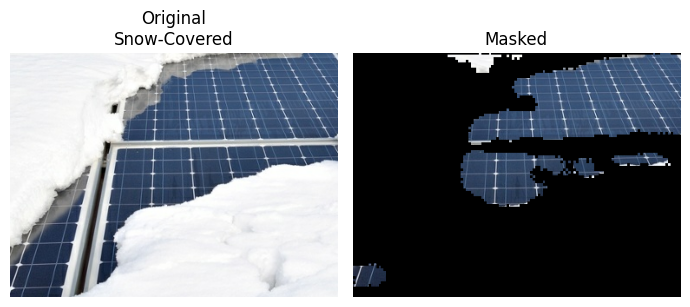

In [140]:
import random, matplotlib.pyplot as plt

# pick some rows that were exported
show_mode = "masked"  # or "cropped"
csv_show = CSV_MASKED if show_mode=="masked" else CSV_CROPPED
df_show = pd.read_csv(csv_show)

samples = df_show.sample(n=min(6, len(df_show)), random_state=7)

for _, row in samples.iterrows():
    # original
    orig = decode_rgb(df.loc[(df.split==row.split) & (df.filepath.str.contains(Path(row.filepath).stem.split('_masked')[0], regex=False)), "filepath"].iloc[0])
    # exported
    exp  = np.array(Image.open(row.filepath))
    if exp.ndim==2: exp = np.repeat(exp[...,None], 3, axis=-1)
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(orig); plt.title(f"Original\n{row.label}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(exp);  plt.title(f"{show_mode.capitalize()}"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [142]:
'''
import sys, subprocess, os
os.makedirs("reports/cls_incv3p_masked", exist_ok=True)
os.makedirs("reports/cls_incv3p_cropped", exist_ok=True)

# Example: MASKED
cmd_masked = [
    sys.executable, "-m", "src.cls.train_cls",
    "--csv", str(CSV_MASKED),
    "--model_name", "inceptionv3_net_proposed",
    "--out", "reports/cls_incv3p_masked",
    "--epochs", "30", "--batch", "32", "--img", "256",
]
print(" ".join(cmd_masked))
_ = subprocess.run(cmd_masked)

# Example: CROPPED
cmd_cropped = [
    sys.executable, "-m", "src.cls.train_cls",
    "--csv", str(CSV_CROPPED),
    "--model_name", "inceptionv3_net_proposed",
    "--out", "reports/cls_incv3p_cropped",
    "--epochs", "30", "--batch", "32", "--img", "256",
]
print(" ".join(cmd_cropped))
_ = subprocess.run(cmd_cropped)
'''

'\nimport sys, subprocess, os\nos.makedirs("reports/cls_incv3p_masked", exist_ok=True)\nos.makedirs("reports/cls_incv3p_cropped", exist_ok=True)\n\n# Example: MASKED\ncmd_masked = [\n    sys.executable, "-m", "src.cls.train_cls",\n    "--csv", str(CSV_MASKED),\n    "--model_name", "inceptionv3_net_proposed",\n    "--out", "reports/cls_incv3p_masked",\n    "--epochs", "30", "--batch", "32", "--img", "256",\n]\nprint(" ".join(cmd_masked))\n_ = subprocess.run(cmd_masked)\n\n# Example: CROPPED\ncmd_cropped = [\n    sys.executable, "-m", "src.cls.train_cls",\n    "--csv", str(CSV_CROPPED),\n    "--model_name", "inceptionv3_net_proposed",\n    "--out", "reports/cls_incv3p_cropped",\n    "--epochs", "30", "--batch", "32", "--img", "256",\n]\nprint(" ".join(cmd_cropped))\n_ = subprocess.run(cmd_cropped)\n'

# Classification Task

#### Available Models: inceptionv3_net_proposed, cnn_plain, mobilenetv3, densenet, vgg16, vgg19, resnet50, inceptionv3_base

## Train the Classifier Models

In [144]:
# Path to your classification CSV
CLS_CSV = "data/classification/localized/splits_localized_cropped.csv" #"data/classification/splits_spfnet.csv"   # change if different

# Train *all* available classifiers from the repo
MODELS = [
    "cnn_plain",
    "mobilenetv3",
    "densenet",
    "vgg16",
    "vgg19",
    "resnet50",
    "inceptionv3_base",
    "inceptionv3_net_proposed",   # the "proposed" head (InceptionV3 backbone)
]

# Shared hyperparams
IMG    = 256
BATCH  = 32
EPOCHS = 30

# Where to dump all runs + summary
RUNS_ROOT = Path("reports/cls_runs")
RUNS_ROOT.mkdir(parents=True, exist_ok=True)

# Environment knobs (helps avoid GPU OOM & spam)
BASE_ENV = os.environ.copy()
BASE_ENV["TF_CPP_MIN_LOG_LEVEL"] = "2"                 # quiet TF logs
BASE_ENV["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"         # let TF grow GPU memory gradually


## Helper Functions

In [147]:
def run_training_and_eval(model_name, csv_path, img, batch, epochs, runs_root, base_env):
    """Train + eval one classifier; return (status, run_dir, metrics_dict or None, stderr_tail)."""
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = runs_root / f"{model_name}"
    run_dir.mkdir(parents=True, exist_ok=True)

    # 1) Train
    train_cmd = [
        sys.executable, "-m", "src.cls.train_cls",
        "--csv",   csv_path,
        "--model_name", model_name,
        "--out",   str(run_dir),
        "--epochs", str(epochs),
        "--batch",  str(batch),
        "--img",    str(img),
    ]
    print(f"\n=== Training {model_name} ===\n$ {' '.join(train_cmd)}")
    train_proc = subprocess.run(train_cmd, capture_output=True, text=True, env=base_env)
    print("---- TRAIN STDOUT (tail) ----\n", train_proc.stdout[-1500:])
    print("---- TRAIN STDERR (tail) ----\n", train_proc.stderr[-1500:])
    if train_proc.returncode != 0:
        return ("TRAIN_FAIL", str(run_dir), None, train_proc.stderr[-2000:])

    # 2) Eval
    eval_dir = run_dir / "eval"
    eval_cmd = [
        sys.executable, "-m", "src.cls.eval_cls",
        "--csv",   csv_path,
        "--model", str(run_dir / "best.keras"),
        "--out",   str(eval_dir),
        "--img",   str(img),
    ]
    print(f"\n=== Evaluating {model_name} ===\n$ {' '.join(eval_cmd)}")
    eval_proc = subprocess.run(eval_cmd, capture_output=True, text=True, env=base_env)
    print("---- EVAL STDOUT (tail) ----\n", eval_proc.stdout[-1500:])
    print("---- EVAL STDERR (tail) ----\n", eval_proc.stderr[-1500:])
    if eval_proc.returncode != 0:
        return ("EVAL_FAIL", str(run_dir), None, eval_proc.stderr[-2000:])

    # 3) Read metrics JSON if present
    metrics_path = eval_dir / "test_metrics.json"
    metrics = None
    if metrics_path.exists():
        try:
            with open(metrics_path, "r", encoding="utf-8") as f:
                metrics = json.load(f)
        except Exception as e:
            print("Could not read test_metrics.json:", e)

    return ("OK", str(run_dir), metrics, eval_proc.stderr[-1000:])


## Train and Evalual ALL classifoer models and build a summary table

In [150]:
results = []
failures = []

for m in MODELS:
    status, run_dir, metrics, err_tail = run_training_and_eval(
        model_name=m,
        csv_path=CLS_CSV,
        img=IMG,
        batch=BATCH,
        epochs=EPOCHS,
        runs_root=RUNS_ROOT,
        base_env=BASE_ENV
    )
    row = {
        "model": m,
        "status": status,
        "run_dir": run_dir,
        "acc": None,
        "macro_f1": None,
        "support": None,
    }
    if metrics:
        # Try to pull common fields; fall back gracefully if keys differ in your eval script
        row["acc"] = metrics.get("accuracy") or metrics.get("test_accuracy") or metrics.get("acc")
        row["macro_f1"] = metrics.get("macro_f1") or metrics.get("f1_macro")
        row["support"] = metrics.get("test_support") or metrics.get("n_test")
    else:
        if status != "OK":
            failures.append((m, status, err_tail))

    results.append(row)

summary_df = pd.DataFrame(results).sort_values(by=["status","acc"], ascending=[True, False])
display(summary_df)

# Save summary
summary_csv = RUNS_ROOT / "summary.csv"
summary_df.to_csv(summary_csv, index=False)
print("Saved summary ->", summary_csv)

if failures:
    print("\nSome models failed:")
    for m, st, err in failures:
        print(f"\n[{m}] {st}\n{err}")



=== Training cnn_plain ===
$ C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.cls.train_cls --csv data/classification/localized/splits_localized_cropped.csv --model_name cnn_plain --out reports\cls_runs\cnn_plain --epochs 30 --batch 32 --img 256
---- TRAIN STDOUT (tail) ----
 ======>...........] - ETA: 0s - loss: 1.7221 - accuracy: 0.2557
17/17 [==============================] - 2s 143ms/step - loss: 1.7199 - accuracy: 0.2443 - val_loss: 1.7197 - val_accuracy: 0.2384
Epoch 7/30

17/17 [==============================] - 2s 121ms/step - loss: 1.7295 - accuracy: 0.2118 - val_loss: 1.7199 - val_accuracy: 0.2384

---- TRAIN STDERR (tail) ----
 

=== Evaluating cnn_plain ===
$ C:\ProgramData\anaconda3\envs\DeepLearningEnvironment\python.exe -m src.cls.eval_cls --csv data/classification/localized/splits_localized_cropped.csv --model reports\cls_runs\cnn_plain\best.keras --out reports\cls_runs\cnn_plain\eval --img 256
---- EVAL STDOUT (tail) ----
 Saved metrics and conf

,model,status,run_dir,acc,macro_f1,support
7,inceptionv3_net_proposed,OK,reports\cls_runs\inceptionv3_net_proposed,0.668508,None,None
2,densenet,OK,reports\cls_runs\densenet,0.640884,None,None
3,vgg16,OK,reports\cls_runs\vgg16,0.618785,None,None
4,vgg19,OK,reports\cls_runs\vgg19,0.580110,None,None
6,inceptionv3_base,OK,reports\cls_runs\inceptionv3_base,0.397790,None,None
5,resnet50,OK,reports\cls_runs\resnet50,0.325967,None,None
1,mobilenetv3,OK,reports\cls_runs\mobilenetv3,0.303867,None,None
0,cnn_plain,OK,reports\cls_runs\cnn_plain,0.232044,None,None


Saved summary -> reports\cls_runs\summary.csv


# View the Permofance Metrics for Each Model

In [111]:
# <<< EDIT ME >>>
PER_CLASS_JSON = "reports/cls_runs/cnn_plain/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/cnn_plain/eval/test_metrics_full.json"

import json
from typing import Dict, List, Any, Union, Set, Optional
import math

def load_metrics_data(file_path: str) -> Dict[str, Any]:
    """
    Load metrics data from a JSON file.
    
    Args:
        file_path: Path to the JSON file containing metrics data
        
    Returns:
        Dictionary containing the loaded metrics data
    """
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_class_keys(data: Dict[str, Any], special_keys: Set[str]) -> List[str]:
    """
    Extract class keys from metrics data by excluding special keys.
    
    Args:
        data: Dictionary containing metrics data
        special_keys: Set of keys to exclude from class keys
        
    Returns:
        List of class keys
    """
    return [k for k in data.keys() if k not in special_keys]

def extract_value(data_dict: Dict[str, Any], *field_names: str, default: float = math.nan) -> float:
    """
    Extract a value from a dictionary using multiple possible field names.
    
    Args:
        data_dict: Dictionary to extract value from
        field_names: Possible field names to look for
        default: Default value to return if no field name is found
        
    Returns:
        Extracted value as float or default value
    """
    for name in field_names:
        if name in data_dict:
            return float(data_dict[name])
    return default

def build_summary(
    data: Dict[str, Any], 
    macro_avg: Dict[str, Any], 
    weighted_avg: Dict[str, Any], 
    class_keys: List[str]
) -> Dict[str, Union[float, int]]:
    """
    Build a summary of metrics from the provided data.
    
    Args:
        data: Dictionary containing metrics data
        macro_avg: Dictionary containing macro average metrics
        weighted_avg: Dictionary containing weighted average metrics
        class_keys: List of class keys
        
    Returns:
        Dictionary containing summarized metrics
    """
    return {
        "accuracy":            float(data.get("accuracy", math.nan)),
        "macro_precision":     extract_value(macro_avg, "precision"),
        "macro_recall":        extract_value(macro_avg, "recall"),
        "macro_f1":            extract_value(macro_avg, "f1-score", "f1"),
        "weighted_precision":  extract_value(weighted_avg, "precision"),
        "weighted_recall":     extract_value(weighted_avg, "recall"),
        "weighted_f1":         extract_value(weighted_avg, "f1-score", "f1"),
        "balanced_accuracy":   extract_value(macro_avg, "recall"),  # alias for macro recall
        "num_classes":         len(class_keys),
        "test_support":        int(extract_value(weighted_avg, "support", default=0)),  # uses weighted.avg support
    }

def find_zero_recall_classes(data: Dict[str, Any], class_keys: List[str]) -> List[str]:
    """
    Find classes with zero recall (never correctly predicted).
    
    Args:
        data: Dictionary containing metrics data
        class_keys: List of class keys
        
    Returns:
        List of class keys with zero recall
    """
    return [k for k in class_keys if extract_value(data[k], "recall", default=0.0) == 0.0]

def save_summary(summary: Dict[str, Any], output_path: str) -> None:
    """
    Save summary metrics to a JSON file.
    
    Args:
        summary: Dictionary containing summary metrics
        output_path: Path to save the JSON file
    """
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2)

def print_summary(summary: Dict[str, Any]) -> None:
    """
    Print summary metrics in a formatted way.
    
    Args:
        summary: Dictionary containing summary metrics
    """
    print("Overall test metrics:")
    for k, v in summary.items():
        print(f"{k:>20}: {v:.6f}" if isinstance(v, float) else f"{k:>20}: {v}")

def main() -> None:
    """
    Main function to process metrics data, build summary, and save results.
    """
    # Load data
    data = load_metrics_data(PER_CLASS_JSON)
    
    # Define special keys and extract class keys
    special_keys = {"accuracy", "macro avg", "weighted avg"}
    class_keys = extract_class_keys(data, special_keys)
    
    # Extract average metrics
    macro_avg = data.get("macro avg", {})      # {precision, recall, f1-score, support}
    weighted_avg = data.get("weighted avg", {})   # {precision, recall, f1-score, support}
    
    # Build summary
    summary = build_summary(data, macro_avg, weighted_avg, class_keys)
    
    # Print summary
    print_summary(summary)
    
    # Find and print classes with zero recall
    zero_recall = find_zero_recall_classes(data, class_keys)
    if zero_recall:
        print("\nClasses with zero recall (no correct predictions):", zero_recall)
    
    # Save summary
    save_summary(summary, OUT_JSON)
    print("\nWrote overall metrics ->", OUT_JSON)

if __name__ == "__main__":
    main()

Overall test metrics:
            accuracy: 0.232044
     macro_precision: 0.038674
        macro_recall: 0.166667
            macro_f1: 0.062780
  weighted_precision: 0.053845
     weighted_recall: 0.232044
         weighted_f1: 0.087407
   balanced_accuracy: 0.166667
         num_classes: 6
        test_support: 181

Classes with zero recall (no correct predictions): ['Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

Wrote overall metrics -> reports/cls_runs/cnn_plain/eval/test_metrics_full.json


## Plain CNN

In [78]:
# <<< EDIT ME >>>
PER_CLASS_JSON = "reports/cls_runs/cnn_plain/eval/test_metrics.json"   # or .csv path
OUT_JSON       = "reports/cls_runs/cnn_plain/eval/test_metrics_full.json"

import json

with open(PER_CLASS_JSON, "r", encoding="utf-8") as f:
    data = json.load(f)

special_keys = {"accuracy", "macro avg", "weighted avg"}
class_keys   = [k for k in data.keys() if k not in special_keys]

macro    = data.get("macro avg", {})      # {precision, recall, f1-score, support}
weighted = data.get("weighted avg", {})   # {precision, recall, f1-score, support}

def pick(d, *names, default=float("nan")):
    for n in names:
        if n in d:
            return float(d[n])
    return default

# Build overall summary
summary = {
    "accuracy":            float(data.get("accuracy", float("nan"))),
    "macro_precision":     pick(macro, "precision"),
    "macro_recall":        pick(macro, "recall"),
    "macro_f1":            pick(macro, "f1-score", "f1"),
    "weighted_precision":  pick(weighted, "precision"),
    "weighted_recall":     pick(weighted, "recall"),
    "weighted_f1":         pick(weighted, "f1-score", "f1"),
    "balanced_accuracy":   pick(macro, "recall"),  # alias for macro recall
    "num_classes":         len(class_keys),
    "test_support":        int(pick(weighted, "support", default=0)),  # uses weighted.avg support
}

print("Overall test metrics:")
for k, v in summary.items():
    print(f"{k:>20}: {v:.6f}" if isinstance(v, float) else f"{k:>20}: {v}")

# Optional: list classes with zero recall (never correctly predicted)
zero_recall = [k for k in class_keys if pick(data[k], "recall", default=0.0) == 0.0]
if zero_recall:
    print("\nClasses with zero recall (no correct predictions):", zero_recall)

# Save alongside your eval artifacts
with open(OUT_JSON, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("\nWrote overall metrics ->", OUT_JSON)

Overall test metrics:
            accuracy: 0.232044
     macro_precision: 0.038674
        macro_recall: 0.166667
            macro_f1: 0.062780
  weighted_precision: 0.053845
     weighted_recall: 0.232044
         weighted_f1: 0.087407
   balanced_accuracy: 0.166667
         num_classes: 6
        test_support: 181

Classes with zero recall (no correct predictions): ['Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']

Wrote overall metrics -> reports/cls_runs/cnn_plain/eval/test_metrics_full.json
